In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.dt_helpers.lif_dynamics import run_LIF_network
from src.dt_helpers.plotters import visualize_network_activity, visualize_spikes

#### keep motor neurons in the circuit

In [13]:
keep_spiking_only = True
# keep_spiking_only = False

weights_minicircuit = np.load("../../data/MANC weights/20241118_T1Lminicircuit/W_20241118_T1Lminicircuit.npy")
table_minicircuit = pd.read_csv("../../data/MANC weights/20241118_T1Lminicircuit/wTable_20241118_T1Lminicircuit.csv")
minicircuit_size = (table_minicircuit["class"] != "motor neuron").sum()

if keep_spiking_only:
    keep_bodyIDs = [10093, 10707, 11751, 13905, 12686]
    keep = table_minicircuit["bodyId"].apply(lambda x: x in keep_bodyIDs)
else:
    send_connections = (weights_minicircuit[np.arange(minicircuit_size)] != 0).any(0)
    receive_connections = (weights_minicircuit[:, np.arange(minicircuit_size)] != 0).any(1)
    keep = send_connections | receive_connections

weights_minicircuit = weights_minicircuit[keep][:, keep]
table_minicircuit = table_minicircuit[keep]
weights_minicircuit[table_minicircuit["class"] == "motor neuron"] = 0

network_size = keep.sum()
network_input = np.zeros(keep.sum())
network_input[table_minicircuit["class"] == "descending neuron"] = 1

network_weights = weights_minicircuit.T

In [14]:
def default_params() -> dict:
    params = {}

    params["V_rest"] = -52e-3  # [V]
    params["V_reset"] = -52e-3  # [V]
    params["V_thresh"] = -45e-3  # [V]
    params["t_refractory"] = 2.2e-3  # [s]
    params["tau_membrane"] = 20e-3  # [s]
    params["tau_synaptic"] = 5e-3  # [s]
    params["w_synaptic"] = 0.275e-3  # [V]
    params["t_delay"] = 1.8e-3  # [s]
    params["membrane_conductance"] = 10e-9  # [S]
    params["V_init"] = -52e-3  # [V]
    params["dt"] = 1e-5  # [s]
    params["simulation_time"] = 0.3  # [s]
    params["network_input"] = 0.15e-9  # [A]
    params["network_size"] = network_size
    params["network_weights"] = network_weights
    return params


params = default_params()

In [15]:
history_V, history_spikes = run_LIF_network(params, network_input)

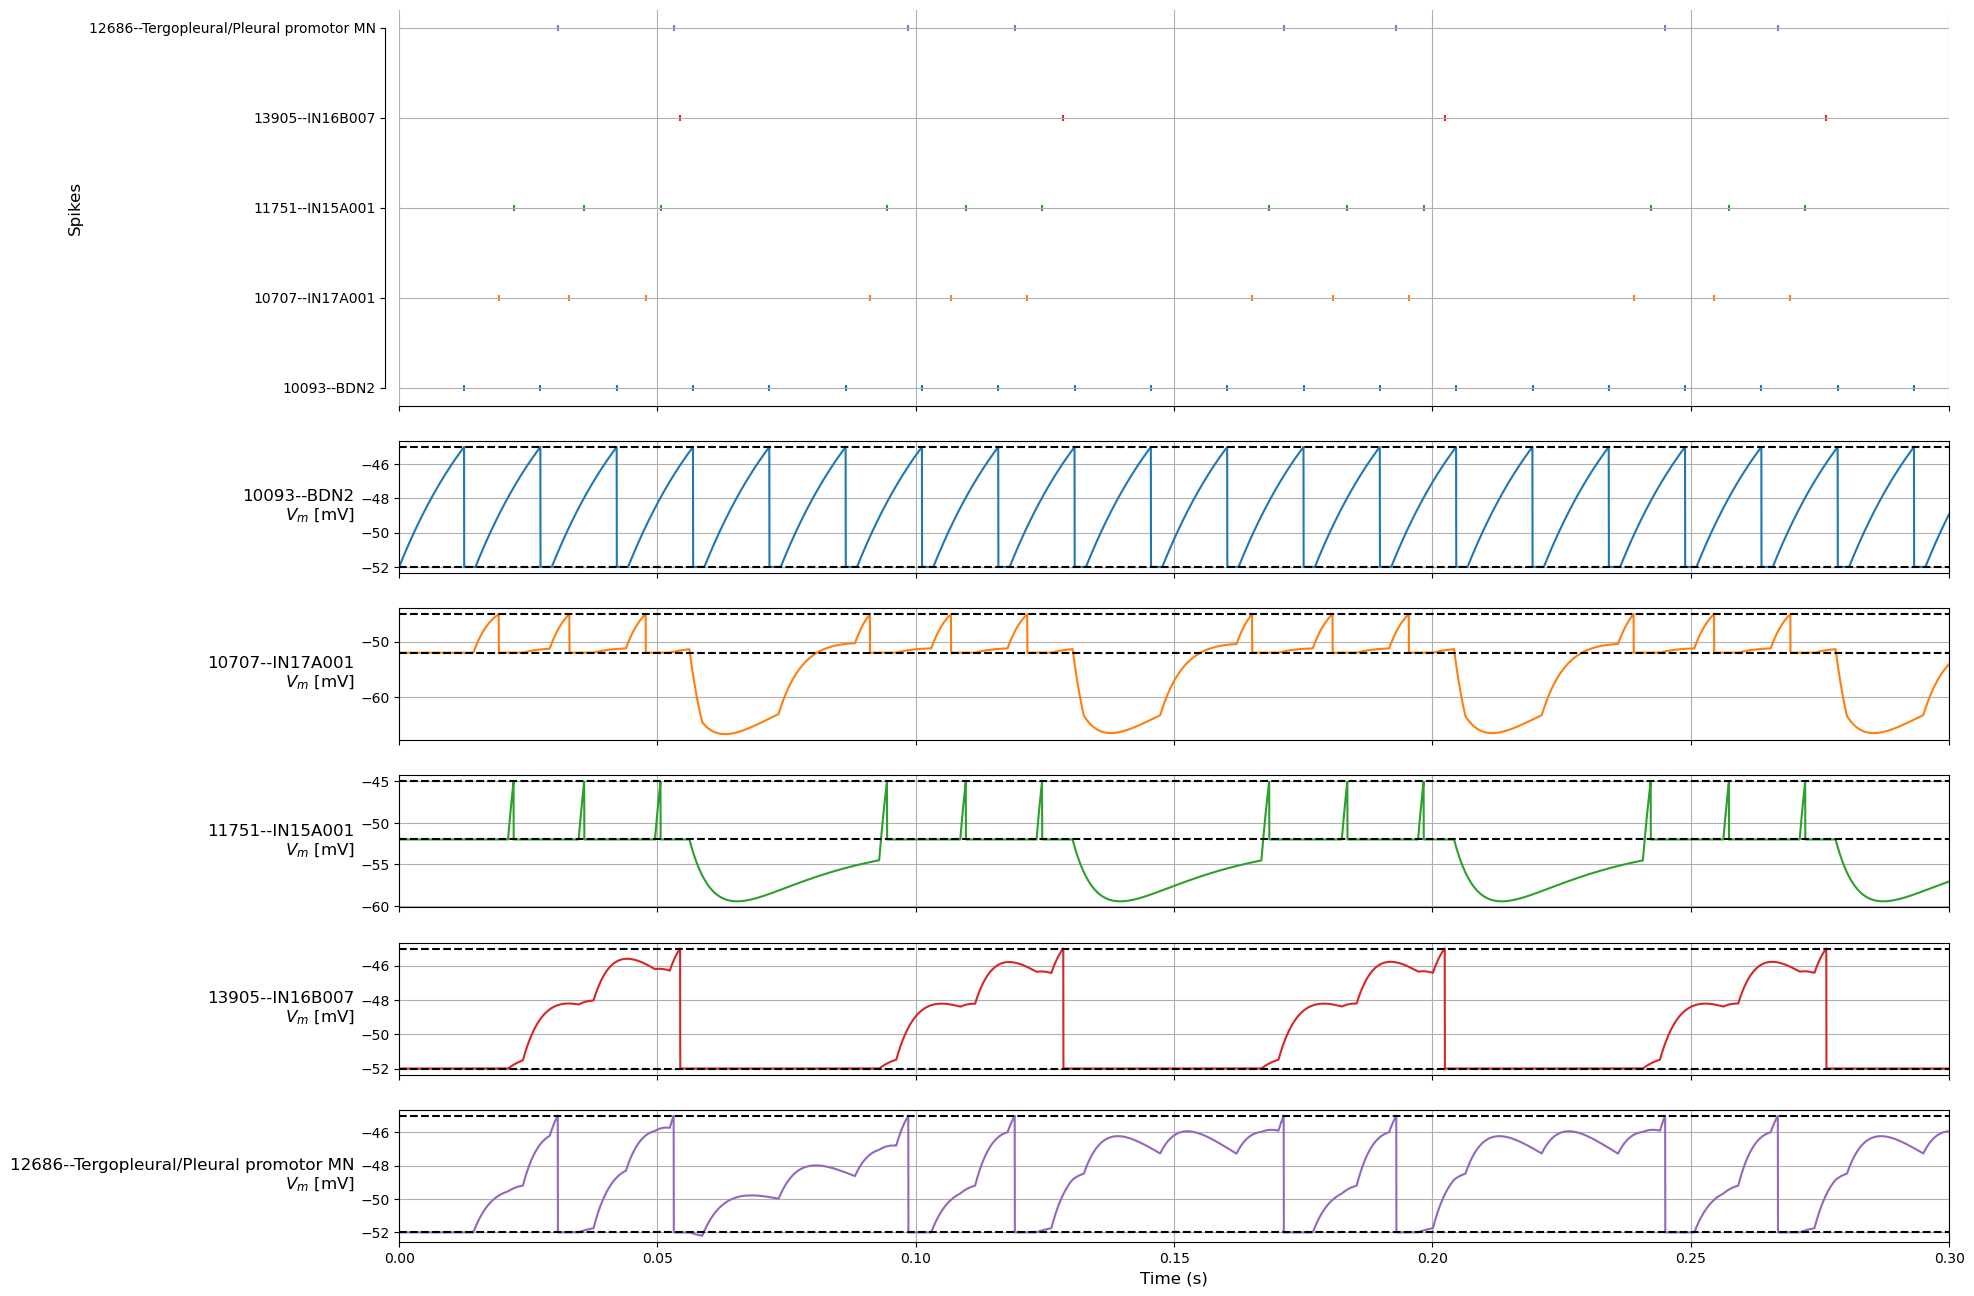

In [16]:
fig, ax = visualize_spikes(
    spike_activity=history_spikes,
    membrane_potential=history_V,
    duration=params["simulation_time"],
    dt=params["dt"],
    neuron_labels=list(table_minicircuit[["bodyId", "type"]].apply(lambda x: f"{x['bodyId']}--{x['type']}", axis=1)),
    spike_marker_size=20,
    spike_figure_height=6,
    y_label_rotation=0,
    show_plot=False,
)
if keep_spiking_only:
    plt.savefig("LIF-model-spiking-only.svg", bbox_inches="tight")
else:
    plt.savefig("LIF-model-all.svg", bbox_inches="tight")
plt.show()

In [11]:
# params["simulation_time"] = 5
# network_inputs = np.arange(0.07, 0.4, 0.005) * 1e-9
# frequencies_mean = {}
# frequencies_std = {}
# for net_in in network_inputs:
#     frequencies_mean[net_in] = []
#     frequencies_std[net_in] = []
#     params["network_input"] = net_in
#     print(f"Running simulation with network input: {net_in:.2e}")
#     history_V, history_spikes = run_LIF_network(params, network_input)
#     for i in range(params["network_size"]):
#         spike_time_ids = np.where(history_spikes[:, i])[0]
#         spike_intervals = np.diff(spike_time_ids)
#         if len(spike_intervals) == 0:
#             frequencies_mean[net_in].append(0)
#             frequencies_std[net_in].append(0)
#             continue
#         middle_interval = (spike_intervals.max() + spike_intervals.min() / 2) / 2
#         burst_start_ids = np.hstack(
#             [[spike_time_ids[0]], spike_time_ids[np.where(spike_intervals >= middle_interval)[0] + 1]]
#         )
#         oscillation_frequency = 1 / (np.diff(burst_start_ids) * params["dt"])
#         frequencies_mean[net_in].append(oscillation_frequency.mean())
#         frequencies_std[net_in].append(oscillation_frequency.std())

In [8]:
# means = np.array([v for v in frequencies_mean.values()])
# stds = np.array([v for v in frequencies_std.values()])
# net_ins = np.array(list(frequencies_mean.keys())) * 1e9
# neuron_labels = ["BDN2", "17A (E)", "15A (E)", "16B (I)"]
# fig, axes = plt.subplots(1, params["network_size"], figsize=(4 * params["network_size"], 4), sharex=True)
# for i in range(params["network_size"]):
#     axes[i].plot(net_ins, means[:, i], c=f"C{i}")
#     axes[i].scatter(net_ins, means[:, i], color=f"C{i}", s=7)
#     axes[i].fill_between(net_ins, means[:, i] - stds[:, i], means[:, i] + stds[:, i], alpha=0.3, color=f"C{i}")
#     axes[i].set_xlabel("Input [nA]")
#     axes[i].set_title(neuron_labels[i])
#     sns.despine(offset=10, trim=True, ax=axes[i])
# axes[0].set_ylabel("Oscillation frequency [Hz]")
# plt.show()